# Introduction

In [1]:
import sys
import os

# Add the path to the parent module
sys.path.append(os.path.abspath('../..'))

In [2]:
import warnings
warnings.filterwarnings('ignore')


import deeppy as dp

import torch
import torch.optim as optim
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym

from assets.tutorial_utils import *

# Important Notes

1) Each class contains print_args method as classmethod, which you can print the arguments dictionary
2) Modules contains a list attributes "algorithms", which returns the name of classes inside

# LearnFrame


Every learning cycle contains a master -LearnFrame- that coordinates a model and a dataset handler. It's purpose is to coordinate the data and the learning algorithm. Thus, the actual training loop uses learning frame. It has basically 3 main methods

```python
def optimize(self):
    #Gets training data from data, and trains the algorithms one step. 
def test(self):
    #Gets test data from data and calculates loss
def collect(self):
    #For RL algorithms, takes one step in the environment using the model prediction
```

Thus a very simple training loop will look like


```python
for epoch in epochs:
    lf.optimize()
    lf.test()
lf.plot([lf.train_data], labels = ["train loss"],show_result= True)
```

In [3]:
from deeppy import LearnFrame
LearnFrame.print_args()

LearnFrame_params = {
    "model",
    "data",
}


# Data 

Data classes are responsible of handling the data. There are two conventions:

    1)They always keep the data in CPU, thus CUDA device is only relevant for the model and netwoks
    2)They always keep the data as torch tensors

It has 3 main methods (train,test,valid), where it returns batched data. And one more method for reinforcement learning algorithms, that interacts with the environment 

```python
def <name>_data(self):
    return data
def collect(self, model):
    #interact with the environment
```

There are 3 type of data class objects right now

In [4]:
from deeppy import data
print(data.algorithms)

['DataGetter', 'EnvData', 'FromLoader']


DataGetter takes X,y,X_test data as input. All torch tensors (Batch_size, dim)

FromLoader takes train_loader, test_loader as input, all torch DataLoader objects

EnvData takes an environment as an input and implements a ReplayBuffer. It has an extra functionality collect(), which will use a model to take a step in environment and automatically store the experience in the ReplayBuffer. It also handles all the interactions with the environment

#### Example
Let's construct a toy dataset where we try to fit a function f()

X shape : torch.Size([2500, 2])
y shape : torch.Size([2500, 1])


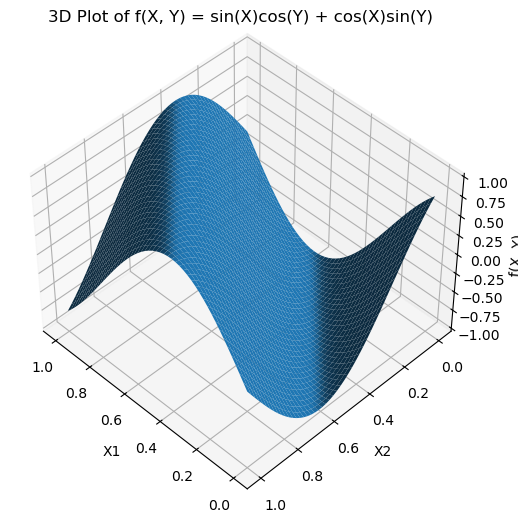

In [5]:
X,y = get_toy_data_and_plot()

In [6]:
from deeppy.data import DataGetter
DataGetter.print_args()

DataGetter_params = {
    "X":None,
    "y":None,
    "X_valid":None,
    "X_test":None,
    "y_test":None,
    "test_size":0.2,
    "test_batch_size":None,
    "valid_batch_size":None,
    "batch_size":64,
    "num_workers":0,
    "pin_memory":True,
    "shuffle":True,
}


- And we simply create our Dataset object

In [7]:
DataGetter_params = {
    "X" : X,
    "y": y,
    "X_valid":None,
    "test_size":0.,
    "test_batch_size":None,
    "valid_batch_size":None,
    "batch_size":128,
    "num_workers":0,
    "pin_memory":True,
    "shuffle":True,
}

data = dp.data.DataGetter(**DataGetter_params)
Xd,yd = data.train_data()

print(Xd.shape)

torch.Size([128, 2])


# Network 

Networks are basic building blocks of our Neural Network functionality and is a subclass of nn.Module.

It consists of a Neural network, an optimizer and a scheduler (optional)

It has 3 modes, encoded as "task" attribute, namely,:

    1) "reg" where it returns the defined architecture output
    
    2) "classify" where it returns (out_layer > 0.5) in Eval mode
    
    3) "autoencoder" where it takes the encoder and decoder architectures seperately. And it implements encode() decode() functions as well

### Architectures and LayerGenerator
The neural network parameters are passed as a dictionary, and parsed by a LayerGenerator object. Layer generator takes a list of repetative layers (arch_params) and create a nn.Sequential object.

The arch_params parameters are as follows:

In [8]:
from deeppy import LayerGenerator, Optimizer, Scheduler
LayerGenerator.print_args()

arch_params = {
    "layers":[],
    "blocks":[],
    "block_args":[],
    "out_act":<class 'torch.nn.modules.linear.Identity'>,
    "out_params":{},
    "weight_init":None,
}


#### Creating the architecture

So let's say we want a network with 2 inputs and 1 output that has:

    1) Linear layer
    2) Dropout
    3) Relu

at every layers.

We want 2 hidden layers, each with 32 neurons. But we want no activation function for the output layer.

And we also want to initialize network weights appropriately for ReLu. (Kaiming). Weight init mode can be:

    1) "uniform"
    2) "normal"
    3) None - No initialization

        Note : For sigmoid and tanh it initializes (Xavier)

Then our arch_params will look like

In [9]:
arch_params = {
    "layers":[2,64,64,1],
    "blocks":[nn.Linear, nn.Dropout, nn.ReLU],
    "block_args":[{}, {"p":0.2}],
    "out_act":nn.Identity,
    "out_params":{},
    "weight_init":"uniform",
}

#### Creating the optimizer and the scheduler
As an optimizer, we will use AdamW with 1e-4 learning rate and amsgrad.

We want to clip the gradient values bigger than 100

And we want a Step scheduler.

    - Note that scheduler params is encapsulated by the optimizer params
    - auto_step : if false, scheduler is not automatically take a step after backpropagation
                you need to use lf.scheduler_step() or model.scheduler_step()

In [10]:
Optimizer.print_args(print_only_this = True)
Scheduler.print_args(print_only_this = True)

Optimizer_params = {
    "configure_optimizer":None,
    "optimizer":<class 'torch.optim.adamw.AdamW'>,
    "optimizer_args":{},
    "clipper":None,
    "clipper_params":{},
    "scheduler_params":None,
}
Scheduler_params = {
    "scheduler",
    "auto_step":True,
    "**kwargs",
}


In [11]:
Scheduler_params = {
    "scheduler" : optim.lr_scheduler.StepLR,
    "gamma":0.01**(1/10000),
    "auto_step":False,
    "step_size" : 1
}

Optimizer_params = {
    "optimizer":optim.AdamW,
    "optimizer_args":{"lr":1e-4, "amsgrad" : True},
    "clipper":torch.nn.utils.clip_grad_value_,
    "clipper_params":{"clip_value" : 100},
    "scheduler_params":Scheduler_params,
}

#### Network

And finally let's construct our networks

    - Note that arch_params is a list of parameters. For example you can add a CNN layer and a Linear layer using two different parameters. See Network advanced tutorial

In [12]:
from deeppy import Network
Network.print_args(print_only_this = True)

Network_params = {
    "arch_params",
    "decoder_params":None,
    "task":'reg',
    "optimizer_params":None,
    "torch_compile":False,
}


In [14]:
Network_params = {
"arch_params":[arch_params],
"decoder_params":None,
"task":'reg',
"optimizer_params":Optimizer_params,
}

net = Network(**Network_params)

X = torch.rand(1,2)
print(f"input : {X}")
print(f"output : {net(X)}")

input : tensor([[0.8757, 0.7409]])
output : tensor([[-0.0375]], grad_fn=<MulBackward0>)


#### Creating Network

# Models





A model is an algorithm like Deep Q-Networks or Autoencoder, that implements an optimization algorithm (loss function) and a/multiple neural network(s).

```python
def predict(self,X):
    #Takes input data and outputs. Algorithm defined

def optimize(self, *X):
    #Takes input data and trains the model one step according to the selected algorithm
```

Currently there are Autoencoders, RL algorithms and a Basic Model. In this example we will use the basic model with the network we have just created. Basic model can implement one Network:

    1) For predict,  inputs   X | outputs Network(x)
    2) For optimize, inputs X,y | outputs loss(y, Network(x)) 

In [15]:
from deeppy.models import Model
print(dp.models.algorithms)
print()
dp.models.Model.print_args(print_only_this = True)

['rl', 'autoencoder', 'BaseModel', 'Model', 'GPT']

Model_params = {
    "network_params",
    "device":None,
    "criterion":MSELoss(),
    "amp":True,
}


In [16]:
Model_params = {
    "network_params":Network_params,
    "device":device,
    "criterion":nn.MSELoss(),
}

model = Model(**Model_params)

In [17]:
model.net

Network(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Identity()
  )
)

# Training

We have our model and data. Let's initialize our LearnFrame and train our network

In [18]:
lf = dp.LearnFrame(model, data)

In [30]:
lf.data.train_data()

(tensor([[0.2245, 0.2245],
         [0.8571, 0.0408],
         [0.1020, 0.8367],
         [0.8163, 0.5918],
         [0.8776, 0.4082],
         [0.5510, 0.9592],
         [0.3061, 0.2857],
         [0.1224, 0.2245],
         [0.4694, 0.4286],
         [0.9796, 0.7755],
         [0.6735, 0.7347],
         [0.9388, 0.3265],
         [0.9388, 0.1224],
         [0.5306, 0.6939],
         [0.8367, 0.0204],
         [0.8980, 0.8163],
         [0.9388, 0.6939],
         [0.6939, 0.4490],
         [0.8163, 0.5714],
         [0.4082, 0.4082],
         [0.1020, 0.5918],
         [0.5306, 0.6735],
         [0.6939, 0.3469],
         [0.1224, 0.8163],
         [0.5510, 0.4082],
         [0.5510, 0.2857],
         [0.9184, 0.4082],
         [0.8163, 0.8776],
         [0.1633, 0.5918],
         [0.4898, 0.7755],
         [0.3265, 0.5306],
         [0.0000, 0.5510],
         [0.8163, 1.0000],
         [0.0000, 0.4898],
         [0.5306, 0.8163],
         [0.0204, 0.5918],
         [0.5510, 0.7347],
 

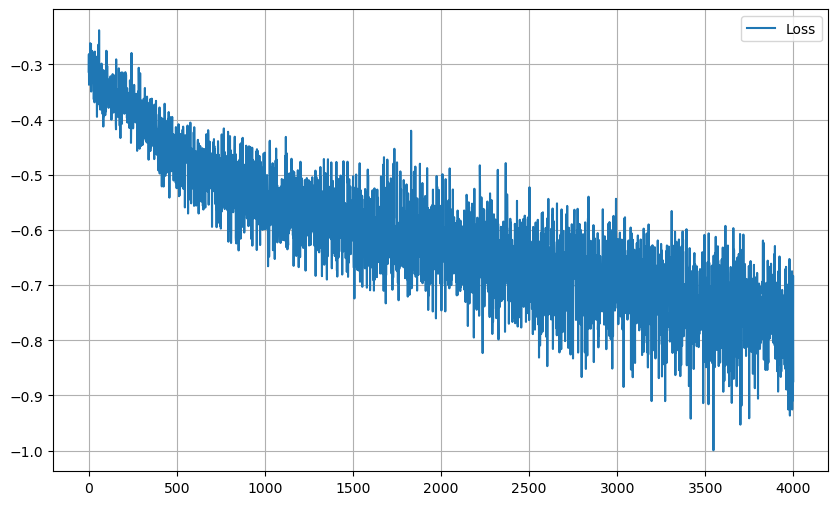

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:
for i in range(1000):
    lf.optimize()
lf.plot(log=True, show_result = True)

# Saving and Loading 

All LearnFrame, Models, and DataClasses come with save(file_name) and load(file_name). 

For example:

#### Save

Just give a folder name

In [23]:
lf.save("checkpoints/intro")

# Load
To load, initialize a LearnFrame with:
    
    1) Appropriate model class 
    2) an initialized object of data class (For environments especially, the environment should be initialized outside)

Then lf.load(folder_name, load_data = True)


In [29]:
from deeppy.models import Model
from deeppy.data import DataGetter
from deeppy import LearnFrame
import numpy as np

data = DataGetter()
lf = LearnFrame(Model, DataGetter())
lf.load("checkpoints/intro", load_data = True)
lf.plot(log=False, show_result = True)

AttributeError: 'Metric' object has no attribute 'env_data'

deeppy.data.dataset.DataGetter